# 02. Finetuning GPT-2 with LoRA

In this example, we fine-tune the pre-trained auto-regressive model, **OpenAI's GPT-2** (small version, 124M parameters), by applying LoRA (Low-Rank Adaptation) optimization.

In this example, I download the pre-trained model from Hugging Face hub, but fine-tune model with regular PyTorch training loop.<br>
(Here I don't use Hugging Face Trainer class.)

See [Readme](https://github.com/tsmatz/finetune_llm_with_lora) for prerequisite's setup.

In [1]:
model_name = "gpt2"

In [2]:
import torch

device = torch.device("cuda")

## Prepare dataset and dataloader

In this example, we use dataset used in [official LoRA example](https://github.com/microsoft/LoRA).

Download dataset from official repository.

In [3]:
!wget https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/train.txt

--2023-10-06 03:27:50--  https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/train.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/train.txt [following]
--2023-10-06 03:27:51--  https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9624463 (9.2M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   9.18M  --.-KB/s    in 0.04s   

2023-10-06 03:27:51 (248 MB/s) - ‘train.txt’ saved [9624463/9624463]



In [4]:
!wget https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/test.txt

--2023-10-06 03:27:54--  https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/test.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/test.txt [following]
--2023-10-06 03:27:54--  https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1351149 (1.3M) [text/plain]
Saving to: ‘test.txt’

test.txt            100%[===================>]   1.29M  --.-KB/s    in 0.006s  

2023-10-06 03:27:54 (208 MB/s) - ‘test.txt’ saved [1351149/1351149]



Show the downloaded data (first 5 rows).

In [5]:
!head -n 5 train.txt

name : The Vaults | Type : pub | price : more than £ 30 | customer rating : 5 out of 5 | near : Café Adriatic||The Vaults pub near Café Adriatic has a 5 star rating . Prices start at £ 30 . 
name : The Cambridge Blue | Type : pub | food : English | price : cheap | near : Café Brazil||Close to Café Brazil , The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of £ 10.50 . Delicious Pub food . 
name : The Eagle | Type : coffee shop | food : Japanese | price : less than £ 20 | customer rating : low | area : riverside | family friendly : yes | near : Burger King||The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £ 20 for Japanese food . 
name : The Mill | Type : coffee shop | food : French | price : £ 20 - 25 | area : riverside | near : The Sorrento||Located near The Sorrento is a French Theme eatery and coffee shop called The Mill , with a price range at £ 20- £ 25 it is in the riverside area . 
name : Loch 

Convert above data into JsonL format.

In [6]:
import sys
import io
import json

def format_convert(read_file, write_file):
    with open(read_file, "r", encoding="utf8") as reader, \
    	 open(write_file, "w", encoding="utf8") as writer :
    	for line in reader:
    		items = line.strip().split("||")
    		context = items[0]
    		completion = items[1].strip("\n")
    		x = {}
    		x["context"] = context
    		x["completion"] = completion
    		writer.write(json.dumps(x)+"\n")

format_convert("train.txt", "train_formatted.jsonl")
format_convert("test.txt", "test_formatted.jsonl")

Show the converted data (first 5 rows).

In [7]:
with open("train_formatted.jsonl", "r") as reader:
    for _ in range(5):
        print(next(reader))

{"context": "name : The Vaults | Type : pub | price : more than \u00a3 30 | customer rating : 5 out of 5 | near : Caf\u00e9 Adriatic", "completion": "The Vaults pub near Caf\u00e9 Adriatic has a 5 star rating . Prices start at \u00a3 30 ."}

{"context": "name : The Cambridge Blue | Type : pub | food : English | price : cheap | near : Caf\u00e9 Brazil", "completion": "Close to Caf\u00e9 Brazil , The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of \u00a3 10.50 . Delicious Pub food ."}

{"context": "name : The Eagle | Type : coffee shop | food : Japanese | price : less than \u00a3 20 | customer rating : low | area : riverside | family friendly : yes | near : Burger King", "completion": "The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than \u00a3 20 for Japanese food ."}

{"context": "name : The Mill | Type : coffee shop | food : French | price : \u00a3 20 - 25 | area : riverside | near : The Sorrento", "com

Load tokenizer from Hugging Face.

In [8]:
from transformers import AutoTokenizer
import os

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    fast_tokenizer=True)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Set block size which is used to separate long text for model consumption.<br>
Max 1024 tokens can be used in GPT-2, but here I set 512, because it's enough for our dataset.

In [9]:
block_size = 512

print(f"Max length of tokens is {tokenizer.model_max_length} in this model.")
print(f"But here we use max {block_size} tokens in the training.")

Max length of tokens is 1024 in this model.
But here we use max 512 tokens in the training.


Create function to convert data. (Later this function is then used in data loader.)<br>
In this function,

1. Tokenize both contexts and compeletions. : e.g, ```"This is a pen."``` --> ```[1212, 318, 257, 3112, 13]```
2. Concatenate context's token and completion's token. (But it's delimited by "\n" between context and completion.) This is used for inputs for LLM.
3. Create labels (targets) with inputs. Label is ```input[1:]``` (i.e, shifted right by one element), and is filled by ```-100``` in context's positions. (See below note.)
4. Pad tokens to make the length of token become ```block_size```.

> Note : Here I set ```-100``` as an ignored index for loss computation, because PyTorch cross-entropy function (```torch.nn.functional.cross_entropy()```) has a property ```ignore_index``` which default value is ```-100```.

In [10]:
from torch.utils.data import DataLoader
import pandas as pd

def fill_ignore_label(l, c):
    l[:len(c) - 1] = [-100] * (len(c) - 1)
    return l

def pad_tokens(tokens, max_seq_length, padding_token):
    res_tokens = tokens[:max_seq_length]
    token_len = len(res_tokens)
    res_tokens = res_tokens + \
        [padding_token for _ in range(max_seq_length - token_len)]
    return res_tokens

def collate_batch(batch):
    # tokenize both context and completion respectively
    # (context and completion is delimited by "\n")
    context_list = list(zip(*batch))[0]
    context_list = [c + "\n" for c in context_list]
    completion_list = list(zip(*batch))[1]
    context_result = tokenizer(context_list)
    context_tokens = context_result["input_ids"]
    context_masks = context_result["attention_mask"]
    completion_result = tokenizer(completion_list)
    completion_tokens = completion_result["input_ids"]
    completion_masks = completion_result["attention_mask"]
    # concatenate token
    inputs = [i + j for i, j in zip(context_tokens, completion_tokens)]
    masks = [i + j for i, j in zip(context_masks, completion_masks)]
    # create label
    eos_id = tokenizer.encode(tokenizer.eos_token)[0]
    labels = [t[1:] + [eos_id] for t in inputs]
    labels = list(map(fill_ignore_label, labels, context_tokens))
    # truncate and pad tokens
    inputs = [pad_tokens(t, block_size, 0) for t in inputs] # OPT and GPT-2 doesn't use pad token (instead attn mask is used)
    masks = [pad_tokens(t, block_size, 0) for t in masks]
    labels = [pad_tokens(t, block_size, -100) for t in labels]
    # convert to tensor
    inputs = torch.tensor(inputs, dtype=torch.int64).to(device)
    masks = torch.tensor(masks, dtype=torch.int64).to(device)
    labels = torch.tensor(labels, dtype=torch.int64).to(device)
    return inputs, labels, masks

Now create PyTorch dataloader with previous function (collator function).

> Note : In this example, data is small and we then load all JSON data in memory.<br>
> When it's large, load data progressively by implementing custom PyTorch dataset. (See [here](https://github.com/tsmatz/decision-transformer) for example.)

In [11]:
batch_size = 8
gradient_accumulation_steps = 16

data = pd.read_json("train_formatted.jsonl", lines=True)
dataloader = DataLoader(
    list(zip(data["context"], data["completion"])),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

## Load model

Load model from Hugging Face.

In [12]:
from transformers import AutoModelForCausalLM, AutoConfig

config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    config=config,
).to(device)

## Generate text (before fine-tuning)

Now run prediction with downloaded model (which is not still fine-tuned).

First we create a function to generate text.

In [13]:
def generate_text(model, input, mask, eos_id, pred_sequence_length):
    predicted_last_id = -1
    start_token_len = torch.sum(mask).cpu().numpy()
    token_len = start_token_len
    with torch.no_grad():
        while (predicted_last_id != eos_id) and \
              (token_len - start_token_len < pred_sequence_length):
            output = model(
                input_ids=input,
                attention_mask=mask,
            )
            predicted_ids = torch.argmax(output.logits, axis=-1).cpu().numpy()
            predicted_last_id = predicted_ids[0][token_len - 1]
            input[0][token_len] = predicted_last_id
            mask[0][token_len] = 1
            token_len = torch.sum(mask).cpu().numpy()
    return input, token_len

Let's test our function and generate text. (Here we stop the text generation when it reaches 15 tokens in prediction.)

In [14]:
eos_id = tokenizer.encode(tokenizer.eos_token)[0]

result = tokenizer("Once upon a time,")
input = result["input_ids"]
mask = result["attention_mask"]
input = pad_tokens(input, block_size, 0)
mask = pad_tokens(mask, block_size, 0)
input = torch.tensor([input], dtype=torch.int64).to(device)
mask = torch.tensor([mask], dtype=torch.int64).to(device)

result_token, result_len = generate_text(
    model,
    input,
    mask,
    eos_id,
    pred_sequence_length=15)
print(tokenizer.decode(result_token[0][:result_len]))

result = tokenizer("My name is Clara and I am")
input = result["input_ids"]
mask = result["attention_mask"]
input = pad_tokens(input, block_size, 0)
mask = pad_tokens(mask, block_size, 0)
input = torch.tensor([input], dtype=torch.int64).to(device)
mask = torch.tensor([mask], dtype=torch.int64).to(device)

result_token, result_len = generate_text(
    model,
    input,
    mask,
    eos_id,
    pred_sequence_length=15)
print(tokenizer.decode(result_token[0][:result_len]))

Once upon a time, the world was a place of great beauty and great danger. The world was
My name is Clara and I am a woman. I am a woman who is a woman. I am a


Now we generate text with our test dataset (5 rows).<br>
As you can see below, it cannot output the completion well, because it's not still fine-tuned.

In [15]:
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2]  # because it's duplicated
test_loader = DataLoader(
    list(zip(test_data["context"], [""] * len(test_data["context"]))),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_batch
)

for i, (input, _, mask) in enumerate(test_loader):
    if i == 5:
        break
    print("********** input **********")
    input_len = torch.sum(mask).cpu().numpy()
    print(tokenizer.decode(input[0][:input_len]))
    result_token, result_len = generate_text(
        model,
        input,
        mask,
        eos_id,
        pred_sequence_length=30)
    print("********** result **********")
    print(tokenizer.decode(result_token[0][:result_len]))

********** input **********
name : Wildwood | Type : pub | food : Indian | area : city centre | family friendly : yes | near : Raja Indian Cuisine

********** result **********
name : Wildwood | Type : pub | food : Indian | area : city centre | family friendly : yes | near : Raja Indian Cuisine

Raja Indian Cuisine : Indian | price : Rs. 1,000 | menu : Indian | menu type : food | menu size :
********** input **********
name : Giraffe | Type : pub | food : Fast food | area : riverside | family friendly : yes | near : Rainbow Vegetarian Café

********** result **********
name : Giraffe | Type : pub | food : Fast food | area : riverside | family friendly : yes | near : Rainbow Vegetarian Café

: Giraffe | Type : pub | food : Fast food | area : riverside | family friendly : yes | near : Rainbow Vegetarian Café
********** input **********
name : The Waterman | Type : pub | food : Italian | price : less than £ 20 | area : city centre | family friendly : yes | near : Raja Indian Cuisine

****

## LoRA (Low-Rank Adaptation)

Now we apply LoRA in our downloaded model.<br>
For semantics of LoRA (Low-Rank Adaptation), see [01-finetune-opt-with-lora.ipynb](./01-finetune-opt-with-lora.ipynb).

For the purpose of your learning, here I manually (from scratch) convert the current model into the model with LoRA.

> Note : You can use ```PEFT``` package to be able to get LoRA model with a few lines of code. (Here I don't use this package.)

Before changing our model, first we check the structure of our model. (See the following result in the cell.)

As you can see below, you cannot find any linear layers in OpenAI's GPT-2 transformer, unlike [Meta's OPT transformer](./01-finetune-opt-with-lora.ipynb). Instead, you will find Conv1D (1D convolution) in transformer.<br>
Here this Conv1D, however, is not ```torch.nn.Conv1d``` and it's a custom layer defined for OpenAI GPT, which works same as a linear layer, but the weights are transposed. (See [this source code](https://github.com/huggingface/transformers/blob/main/src/transformers/pytorch_utils.py) for custom ```pytorch_utils.Conv1D``` implementation.)<br>
This custom Conv1D layer (intrinsically, a linear layer) is used for MLP and getting key/value/query in GPT-2 transformer as follows.<br>
(See [source code](https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py) for GPT-2 in Hugging Face tarnsformers.)

- ```transformer.h.n.attn.c_attn``` : Layer to get key/value/query before processing attention.
- ```transformer.h.n.attn.c_proj``` : Layer for projection after processing attention.
- ```transformer.h.n.mlp.c_attn``` : MLP in GPT-2 is Linear(GeLU(Linear)). This is an inner Linear layer (custom Conv1D).
- ```transformer.h.n.mlp.c_proj``` : MLP in GPT-2 is Linear(GeLU(Linear)). This is an outer Linear layer (custom Conv1D).

According to the practice in [paper](https://arxiv.org/abs/2106.09685), LoRA is applied only to query and value projections. In this example, however, we'll convert ```transformer.h.n.attn.c_attn``` layer (which is a projection layer for entire key/value/query) into LoRA layers.<br>
The transformer in GPT-2 with 124M parameters has 12 layers and it then has total 12 layers (n=0,1, ... , 11) to be converted.

In [16]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

First we build custom linear layer with LoRA as follows.

In [17]:
import math
from torch import nn

class LoRA_Linear(nn.Module):
    def __init__(self, weight, bias, lora_dim):
        super().__init__()

        row, column = weight.shape

        # restore Linear
        if bias is None:
            self.linear = nn.Linear(column, row, bias=False)
            self.linear.load_state_dict({"weight": weight})
        else:
            self.linear = nn.Linear(column, row)
            self.linear.load_state_dict({"weight": weight, "bias": bias})

        # create LoRA weights (with initialization)
        self.lora_right = nn.Parameter(torch.zeros(column, lora_dim))
        nn.init.kaiming_uniform_(self.lora_right, a=math.sqrt(5))
        self.lora_left = nn.Parameter(torch.zeros(lora_dim, row))

    def forward(self, input):
        x = self.linear(input)
        y = input @ self.lora_right @ self.lora_left
        return x + y

Replace targeting linear layers with LoRA layers.<br>
As I have mentioned above, custom Conv1D layer in GPT-2 is intrinsically equivalent to a linear layer, in which the weights are transposed.

> Note : According to the practice in [paper](https://arxiv.org/abs/2106.09685), LoRA is applied only to query and value projections with $r=4$.<br>
> In this example, however, I set $r=8$.

In [18]:
lora_dim = 8

# get target module name
target_names = []
for name, module in model.named_modules():
    if "attn.c_attn" in name:
        target_names.append(name)

# replace each module with LoRA
for name in target_names:
    name_struct = name.split(".")
    # get target module
    module_list = [model]
    for struct in name_struct:
        module_list.append(getattr(module_list[-1], struct))
    # build LoRA
    lora = LoRA_Linear(
        weight = torch.transpose(module_list[-1].weight, 0, 1),
        bias = module_list[-1].bias,
        lora_dim = lora_dim,
    ).to(device)
    # replace
    module_list[-2].__setattr__(name_struct[-1], lora)

See how model is changed.

In [19]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): LoRA_Linear(
            (linear): Linear(in_features=768, out_features=2304, bias=True)
          )
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

Finally, freeze all parameters except for LoRA parameters.

In [20]:
for name, param in model.named_parameters():
    if "lora_right" in name or "lora_left" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
### Do this when you run adapter fine-tuning on Hugging Face framework
# model.gradient_checkpointing_enable()
# model.enable_input_require_grads()

## Fine-tune

Now let's start to run fine-tuning.

First we build optimizer as follows.

In [21]:
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=0.0002,
    betas=(0.9, 0.999),
    eps=1e-6,
)

In this example, we build linear scheduler for training.

In [22]:
from torch.optim.lr_scheduler import LambdaLR

num_epochs = 2
num_warmup_steps = 500

num_update_steps = math.ceil(len(dataloader) / gradient_accumulation_steps)
def _get_linear_schedule(current_step):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(0.0, float(num_update_steps * num_epochs - current_step) / float(max(1, num_update_steps * num_epochs - num_warmup_steps)))
scheduler = LambdaLR(optimizer, lr_lambda=_get_linear_schedule)

Run fine-tuning.

In [23]:
from torch.nn import functional as F

if os.path.exists("loss.txt"):
    os.remove("loss.txt")

for epoch in range(num_epochs):
    optimizer.zero_grad()
    model.train()
    for i, (inputs, labels, masks) in enumerate(dataloader):
        with torch.set_grad_enabled(True):
            outputs = model(
                input_ids=inputs,
                attention_mask=masks,
            )
            loss = F.cross_entropy(outputs.logits.transpose(1,2), labels)
            loss.backward()
            if ((i + 1) % gradient_accumulation_steps == 0) or \
               (i + 1 == len(dataloader)):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            print(f"Epoch {epoch+1} {math.ceil((i + 1) / gradient_accumulation_steps)}/{num_update_steps} - loss: {loss.item() :2.4f}", end="\r")

        # record loss
        with open("loss.txt", "a") as f:
            f.write(str(loss.item()))
            f.write("\n")
    print("")

# save model
torch.save(model.state_dict(), "finetuned_gpt2.bin")

Epoch 1 329/329 - loss: 2.1773
Epoch 2 329/329 - loss: 1.1991


> Note : Here we save LoRA-enabled model without any changes, but you can also merge the trained LoRA's parameters into the original model's weights.

Show loss transition in plot.

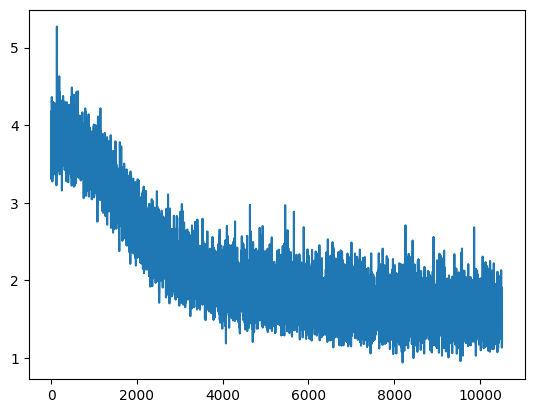

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("loss.txt")
plt.plot(data)
plt.show()

## Generate text with fine-tuned model

Again we check results with our test dataset (5 rows).<br>
As you can see below, it can output the completion very well, because it's fine-tuned.

In [25]:
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2]  # because it's duplicated
test_loader = DataLoader(
    list(zip(test_data["context"], [""] * len(test_data["context"]))),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_batch
)

for i, (input, _, mask) in enumerate(test_loader):
    if i == 5:
        break
    print("********** input **********")
    input_len = torch.sum(mask).cpu().numpy()
    print(tokenizer.decode(input[0][:input_len]))
    result_token, result_len = generate_text(
        model,
        input,
        mask,
        eos_id,
        pred_sequence_length=30)
    print("********** result **********")
    print(tokenizer.decode(result_token[0][:result_len]))

********** input **********
name : The Vaults | Type : pub | food : Italian | price : less than £ 20 | customer rating : low | area : city centre | family friendly : no | near : Rainbow Vegetarian Café

********** result **********
name : The Vaults | Type : pub | food : Italian | price : less than £ 20 | customer rating : low | area : city centre | family friendly : no | near : Rainbow Vegetarian Café
The Vaults is a pub near the Rainbow Vegetarian Café in the city centre. It is not family friendly and has a low customer rating of less than
********** input **********
name : The Cricketers | Type : restaurant | customer rating : average | family friendly : yes | near : Café Sicilia

********** result **********
name : The Cricketers | Type : restaurant | customer rating : average | family friendly : yes | near : Café Sicilia
The Cricketers is a restaurant near Café Sicilia. It is family friendly and has an average customer rating.<|endoftext|>
********** input **********
name : The Cr